##### Балансировка классов
Классы "Yumemi" и "not Yumemi" обучающей выборки довольно несбалансированы (740 против 2020). Наша цель — надёжно распознавать реплики Юмэми, чтобы затем эффективно находить их в новых данных. При этом важно сохранить высокую точность и минимизировать ошибки на остальных классах.

**Методы балансировки для бинарной задачи**:
1) Параметр "class_weight='balanced'" в модели логистической регрессии (не меняет данные, лишь подстраивает веса ошибки).
2) Параметр "class_weight" в Random Forest (sklearn) — аналогично логистической регрессии балансирует веса классов, влияя на критерий разбиения и обучение деревьев.
3) Параметры для балансировки в градиентном бустинге (LightGBM или XGBoost):
   - "scale_pos_weight" — вес положительного класса, обычно равен отношению размера мажоритарного класса к миноритарному. Помогает модели учитывать дисбаланс без изменения данных.
   - "is_unbalance" (только для LightGBM) — автоматически учитывает дисбаланс классов.
4) Oversampling целевого класса с помощью SMOTE или RandomOverSampler.
5) Undersampling уменьшает размер мажоритарного класса.

Судя по результатам тестов, умеренный дисбаланс классов в (≈ 2.73:1) не помешал работе моделей благодаря применению встроенных параметров и использованию адекватных эмбеддингов. Мы ограничимся стандартными методами балансировки, без ресэмплинга.


______________
##### 3.1.1. Случайный лес (первая игра): train/test 80/20

Index(['character', 'type', 'text', 'embedding'], dtype='object')
F-мера на кросс-валидации (5 фолдов): 0.768 ± 0.012

Оптимальный порог по F-мере на обучающей выборке: 0.260 (F1 = 0.994)
Модель сохранена в random_forest_model.pkl

Классификационный отчёт RF (первая игра):
              precision    recall  f1-score   support

  not Yumemi       0.97      0.93      0.95       404
      Yumemi       0.83      0.92      0.87       148

    accuracy                           0.93       552
   macro avg       0.90      0.92      0.91       552
weighted avg       0.93      0.93      0.93       552



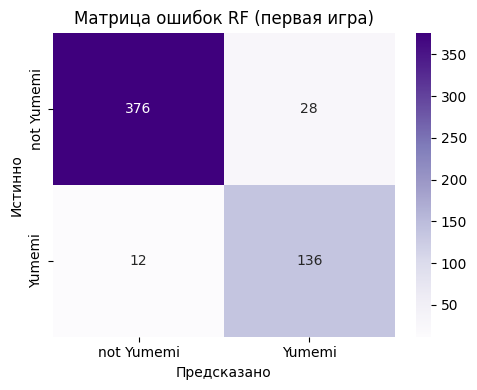

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

df = pd.read_pickle("planetarian_with_bert_embeddings.pkl")

# Проверим содержимое колонок
print(df.columns)

# Бинарная метка: 1 — yumemi, 0 — not yumemi
df['label'] = df['character'].apply(lambda x: 1 if str(x).strip().lower() == 'yumemi' else 0)

# Признаки и метки
X = np.stack(df['embedding'].values)
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Используем случайный лес с балансировкой классов
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced',
                             random_state=42)

# Кросс-валидация для оценки качества
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1')

print(f"F-мера на кросс-валидации (5 фолдов): {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")

# Обучаем модель
clf.fit(X_train, y_train)

# Подбор оптимального порога на обучающей выборке
train_probs = clf.predict_proba(X_train)[:, 1]
best_thresh = 0.5
best_f1 = 0.0
for t in np.arange(0.0, 1.01, 0.01):
    preds = (train_probs >= t).astype(int)
    f1 = f1_score(y_train, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"\nОптимальный порог по F-мере на обучающей выборке: {best_thresh:.3f} (F1 = {best_f1:.3f})")

# Сохраняем модель
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(clf, f)
print("Модель сохранена в random_forest_model.pkl")

# Предсказания вероятностей на тесте
test_probs = clf.predict_proba(X_test)[:, 1]

# Применяем оптимальный порог
y_pred = (test_probs >= best_thresh).astype(int)

# Оценка качества классификации
print("\nКлассификационный отчёт RF (первая игра):")
print(classification_report(y_test, y_pred, 
                            target_names=["not Yumemi", "Yumemi"]))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Purples",
    xticklabels=["not Yumemi", "Yumemi"],
    yticklabels=["not Yumemi", "Yumemi"]
)
plt.xlabel("Предсказано")
plt.ylabel("Истинно")
plt.title("Матрица ошибок RF (первая игра)")
plt.tight_layout()
plt.show()


##### 3.1.2. Случайный лес (вторая игра): val/test 10/90

In [15]:
import pandas as pd
import torch
from transformers import BertJapaneseTokenizer, BertModel
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Загружаем модель случайного леса
with open("random_forest_model.pkl", "rb") as f:
    clf = pickle.load(f)

# Генерируем эмбеддинги BERT
def get_embeddings(texts, tokenizer, model, device):
    embeddings = []
    for text in tqdm(texts, desc="Генерация эмбеддингов"):
        inputs = tokenizer(text, return_tensors="pt", padding=True,
                           truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        cls_emb = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        embeddings.append(cls_emb)
    return np.array(embeddings)

# Загружаем BERT-модель
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertJapaneseTokenizer.from_pretrained("cl-tohoku/bert-base-japanese",
                                                  do_word_tokenize=False)
model = BertModel.from_pretrained("cl-tohoku/bert-base-japanese")
model.to(device)
model.eval()


df = pd.read_csv("snow_globe_cleaned.csv")
df['label'] = df['character'].apply(lambda x: 1 if "Yumemi" in str(x) else 0)

# Делим выборку на валидацию и тест (10/90)
df_val, df_test = train_test_split(df, test_size=0.90,
                                   stratify=df['label'], random_state=42)

# Получаем эмбеддинги для валидации и теста
X_val = get_embeddings(df_val['text'].astype(str).tolist(),
                       tokenizer, model, device)
y_val = df_val['label'].values
X_test = get_embeddings(df_test['text'].astype(str).tolist(),
                        tokenizer, model, device)
y_test = df_test['label'].values

# Получаем вероятности предсказания на валидации
val_probs = clf.predict_proba(X_val)[:, 1]

# Подбираем оптимальный порог по F-мере
best_thresh = 0.0
best_score = 0.0
for threshold in np.arange(0.0, 1.01, 0.01):
    preds = (val_probs >= threshold).astype(int)
    score = f1_score(y_val, preds)
    if score > best_score:
        best_score = score
        best_thresh = threshold

print(f"Оптимальный порог по F-мере на валидации: {best_thresh:.2f} (F1 = {best_score:.3f})")

# Применяем порог к тестовой выборке
test_probs = clf.predict_proba(X_test)[:, 1]
y_pred_test = (test_probs >= best_thresh).astype(int)

df_test = df_test.copy()
df_test['pred_prob'] = test_probs
df_test['pred_label'] = y_pred_test

Генерация эмбеддингов: 100%|██████████| 709/709 [00:48<00:00, 14.69it/s]


Оптимальный порог по F-мере на валидации: 0.46 (F1 = 0.769)



Классификационный отчёт RF (вторая игра):
              precision    recall  f1-score   support

  not Yumemi       0.97      0.97      0.97       648
      Yumemi       0.67      0.72      0.69        61

    accuracy                           0.94       709
   macro avg       0.82      0.84      0.83       709
weighted avg       0.95      0.94      0.95       709



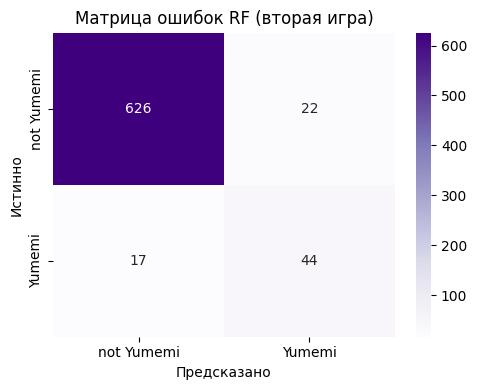

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("\nКлассификационный отчёт RF (вторая игра):")
print(classification_report(y_test, y_pred_test,
                            target_names=["not Yumemi", "Yumemi"]))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["not Yumemi", "Yumemi"],
            yticklabels=["not Yumemi", "Yumemi"])
plt.xlabel("Предсказано")
plt.ylabel("Истинно")
plt.title("Матрица ошибок RF (вторая игра)")
plt.tight_layout()
plt.show()

# Сохраняем ошибочные примеры
df_test['true_label'] = y_test
df_test['pred_label'] = y_pred_test
df_errors = df_test[df_test['true_label'] != df_test['pred_label']]
#df_errors.to_csv("snow_globe_test_errors_rf.csv", index=False)

#print(f"\n{len(df_errors)} ошибочных примеров сохранено в 'snow_globe_test_errors_rf.csv'")

__________
##### 3.2.1. Градиентный бустинг (LightGBM) на выборке из первой игры

Кросс-валидация: 100%|██████████| 5/5 [00:32<00:00,  6.50s/it]



Средняя F-мера на кросс-валидации: 0.876 ± 0.018
Модель сохранена в lightgbm_model.pkl

Классификационный отчёт LightGBM (первая игра):
              precision    recall  f1-score   support

  not Yumemi       0.94      0.99      0.96       404
      Yumemi       0.96      0.82      0.88       148

    accuracy                           0.94       552
   macro avg       0.95      0.90      0.92       552
weighted avg       0.94      0.94      0.94       552



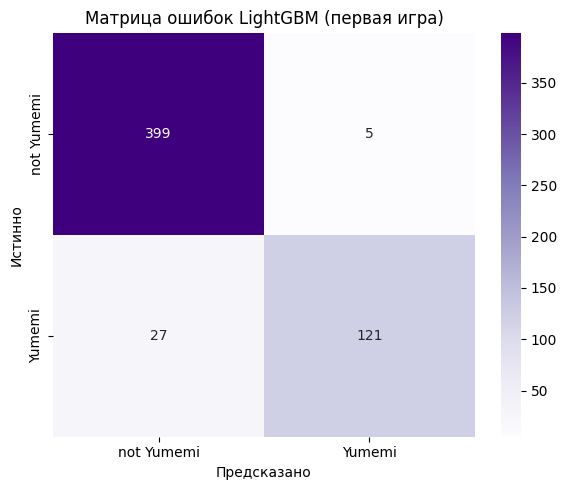

In [17]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm  # импорт tqdm

# Загрузка данных
df = pd.read_pickle("planetarian_with_bert_embeddings.pkl")

# Создание бинарной метки: 1 — Yumemi, 0 — не Yumemi
df['label'] = df['character'].str.strip().str.lower().eq('yumemi').astype(int)

# Признаки и метки
X = np.stack(df['embedding'].values)
y = df['label'].values

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Параметры LightGBM
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'is_unbalance': True,  # включаем автоматическую балансировку
    'verbose': -1,
    'seed': 42
}

# Кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []

for train_idx, val_idx in tqdm(cv.split(X_train, y_train),
                               total=5, desc="Кросс-валидация"):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    train_set = lgb.Dataset(X_tr, label=y_tr)
    val_set = lgb.Dataset(X_val, label=y_val, reference=train_set)

    model = lgb.train(
        params,
        train_set,
        num_boost_round=1000,
        valid_sets=[val_set],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    # Предсказания на валидационном наборе
    val_probs = model.predict(X_val, num_iteration=model.best_iteration)
    val_pred = (val_probs >= 0.5).astype(int)
    
    # Вычисление F-меры
    f1 = f1_score(y_val, val_pred)
    f1_scores.append(f1)

print(f"\nСредняя F-мера на кросс-валидации: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")

# Обучение финальной модели
final_train_data = lgb.Dataset(X_train, label=y_train)
final_model = lgb.train(params, final_train_data, num_boost_round=1000)

# Сохранение модели
with open("lightgbm_model.pkl", "wb") as f:
    pickle.dump(final_model, f)
print("Модель сохранена в lightgbm_model.pkl")

# Предсказания на тесте с порогом 0.5
test_probs = final_model.predict(X_test)
y_pred = (test_probs >= 0.5).astype(int)

# Результаты
print("\nКлассификационный отчёт LightGBM (первая игра):")
print(classification_report(y_test, y_pred,
                            target_names=["not Yumemi", "Yumemi"]))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Purples",
    xticklabels=["not Yumemi", "Yumemi"],
    yticklabels=["not Yumemi", "Yumemi"]
)
plt.xlabel("Предсказано")
plt.ylabel("Истинно")
plt.title("Матрица ошибок LightGBM (первая игра)")
plt.tight_layout()
plt.show()


##### 3.2.2. Градиентный бустинг (LightGBM) на выборке из второй игры

In [18]:
import pandas as pd
import torch
from transformers import BertJapaneseTokenizer, BertModel
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Загружаем модель LightGBM
with open("lightgbm_model.pkl", "rb") as f:
    model = pickle.load(f)

# Генерируем эмбеддинги BERT
def get_embeddings(texts, tokenizer, model_bert, device):
    embeddings = []
    for text in tqdm(texts, desc="Генерация эмбеддингов"):
        inputs = tokenizer(text, return_tensors="pt", padding=True,
                           truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model_bert(**inputs)
        cls_emb = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        embeddings.append(cls_emb)
    return np.array(embeddings)

# Загружаем BERT-модель
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertJapaneseTokenizer.from_pretrained("cl-tohoku/bert-base-japanese",
                                                  do_word_tokenize=False)
model_bert = BertModel.from_pretrained("cl-tohoku/bert-base-japanese")
model_bert.to(device)
model_bert.eval()

df = pd.read_csv("snow_globe_cleaned.csv")
df['label'] = df['character'].apply(lambda x: 1 if "Yumemi" in str(x) else 0)

df_val, df_test = train_test_split(df, test_size=0.90,
                                   stratify=df['label'], random_state=42)

# Получаем эмбеддинги для валидации и теста
X_val = get_embeddings(df_val['text'].astype(str).tolist(),
                       tokenizer, model_bert, device)
y_val = df_val['label'].values
X_test = get_embeddings(df_test['text'].astype(str).tolist(),
                        tokenizer, model_bert, device)
y_test = df_test['label'].values

# Предсказание вероятностей на валидации
val_probs = model.predict(X_val)

# Подбираем оптимальный порог по F-мере
best_thresh = 0.0
best_score = 0.0
for threshold in np.arange(0.0, 1.01, 0.01):
    preds = (val_probs >= threshold).astype(int)
    score = f1_score(y_val, preds)
    if score > best_score:
        best_score = score
        best_thresh = threshold

print(f"Оптимальный порог по F-мере на валидации: {best_thresh:.2f} (F-мера = {best_score:.3f})")

# Применяем оптимальный порог к тесту
test_probs = model.predict(X_test)
y_pred_test = (test_probs >= best_thresh).astype(int)

df_test = df_test.copy()
df_test['pred_prob'] = test_probs
df_test['pred_label'] = y_pred_test

Генерация эмбеддингов: 100%|██████████| 709/709 [00:51<00:00, 13.73it/s]


Оптимальный порог по F-мере на валидации: 0.96 (F-мера = 0.933)



Классификационный отчёт LightGBM (вторая игра):
              precision    recall  f1-score   support

  not Yumemi       0.98      0.98      0.98       648
      Yumemi       0.77      0.75      0.76        61

    accuracy                           0.96       709
   macro avg       0.87      0.87      0.87       709
weighted avg       0.96      0.96      0.96       709



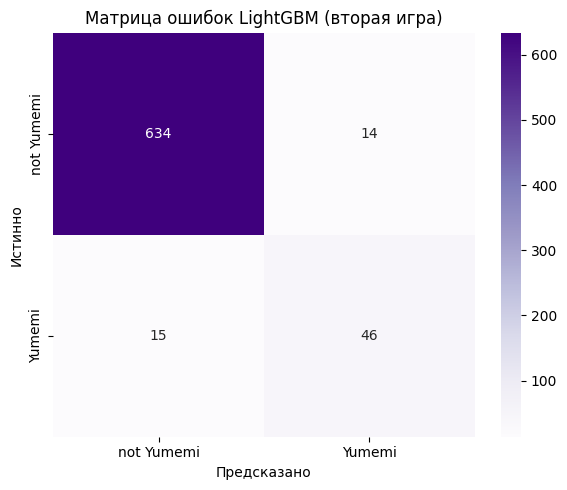


29 ошибочных примеров сохранено в 'snow_globe_test_errors_lightgbm.csv'


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Классификационный отчет
print("\nКлассификационный отчёт LightGBM (вторая игра):")
print(classification_report(y_test, y_pred_test, target_names=["not Yumemi", "Yumemi"]))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["not Yumemi", "Yumemi"],
            yticklabels=["not Yumemi", "Yumemi"])
plt.xlabel("Предсказано")
plt.ylabel("Истинно")
plt.title("Матрица ошибок LightGBM (вторая игра)")
plt.tight_layout()
plt.show()

# Сохраняем ошибочные примеры
df_test = df_test.copy()
df_test['pred_label'] = y_pred_test  # добавляем предсказания

# Отбираем ошибки
df_errors = df_test[df_test['label'] != df_test['pred_label']]

# Переупорядочим колонки
df_errors = df_errors[['character', 'type', 'text', 'label', 'pred_label']]

df_errors.to_csv("snow_globe_test_errors_lightgbm.csv", index=False)
print(f"\n{len(df_errors)} ошибочных примеров сохранено в 'snow_globe_test_errors_lightgbm.csv'")


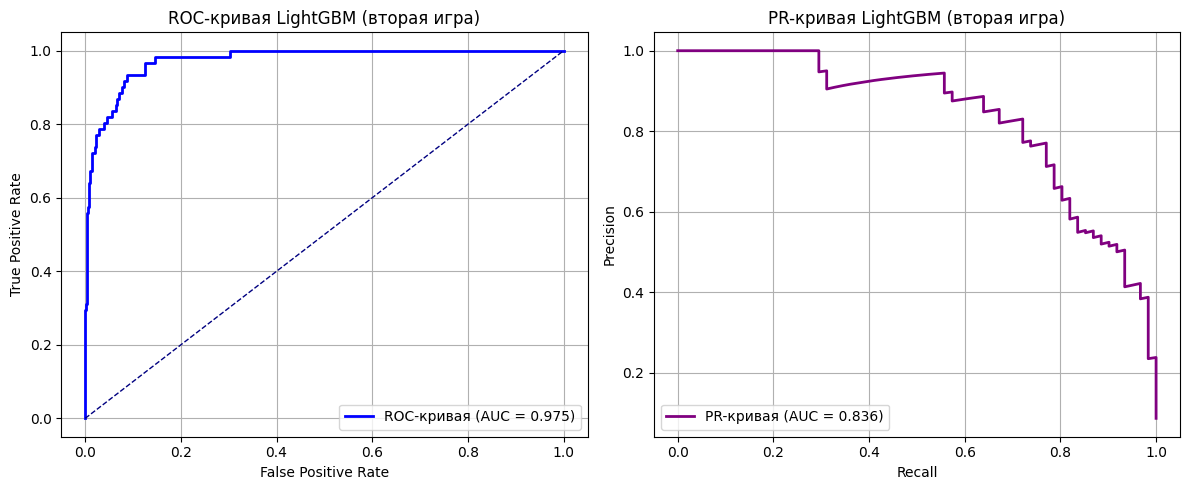

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

# PR-кривая
precision, recall, _ = precision_recall_curve(y_test, test_probs)
pr_auc = auc(recall, precision)

# Визуализация
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Слева ROC
axs[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC-кривая (AUC = {roc_auc:.3f})')
axs[0].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC-кривая LightGBM (вторая игра)')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Справа PR
axs[1].plot(recall, precision, color='purple', lw=2, label=f'PR-кривая (AUC = {pr_auc:.3f})')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('PR-кривая LightGBM (вторая игра)')
axs[1].legend(loc='lower left')
axs[1].grid(True)

plt.tight_layout()
plt.show()


- PR AUC = 0.836 (у логрег был 0.815), прирост в 2.6%. Качество ранжирования немного улучшилось.
___

- Градиентный бустинг последовательно строит ансамбль слабых моделей, каждая из которых исправляет ошибки предыдущих. Это позволяет модели эффективно захватывать сложные зависимости и паттерны в данных, особенно при работе с высокоразмерными и неявными признаками, как в случае с BERT-эмбеддингами.
- Модель логистической регрессии допустила меньше всего FN, что важно для задачи идентификации реплик, несмотря на большее общее количество ошибок (34), чем у градиентного бустинга (29).
- Меньше FN → максимальное покрытие всех фраз Юмэми → минимальный риск пропустить реплику.
- Случайный лес справился хуже, потому что переобучился на первую игру и не смог адаптироваться к изменениям стиля и контекста, в отличие от более устойчивых LightGBM и логистической регрессии.

Итак, несмотря на то, что все три модели отлично распознали класс "not Yumemi", логистическая регрессия справилась с задачей бинарной классификации лучше остальных моделей (меньше всего FN у класса "Yumemi"), LightGBM на втором месте, а случайный лес показал наиболее неудовлетворительный результат.